# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [37]:
import pandas as pd
import os
from sqlalchemy import create_engine

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re
import pickle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linhh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterMessage', con=engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<BarContainer object of 10 artists>

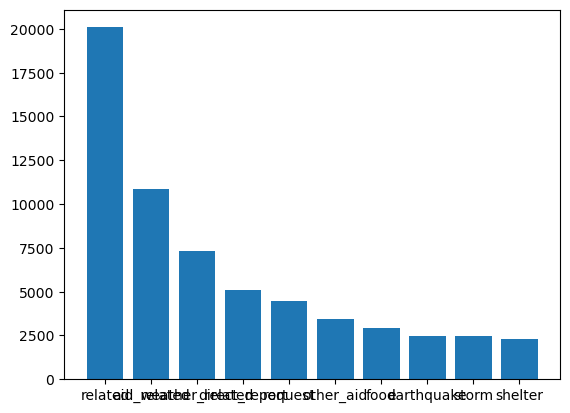

In [44]:
import matplotlib.pyplot as plt


df2 = df[df.columns[4:]].sum(axis=0).sort_values(ascending=False)[:10]
plt.bar(df2.index, df2.values)

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text: str) -> list[str]:
    stop_words = stopwords.words("english")

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text.lower())

    # lemmatize and remove stop words
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens if w not in stop_words]
    tokens = ['null'] if len(tokens)==0 else tokens

    return tokens


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [ ]:
# pipeline = Pipeline([
#     ('countv', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10)))
# ])

In [ ]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text: str):
        # tokenize each sentence into words and tag part of speech
        tokens = tokenize(text)
        pos_tags = nltk.pos_tag([tokens[0]])

        # index pos_tags to get the first word and part of speech tag
        # first_word, first_tag = pos_tags[0]
        try:
            first_word, first_tag = pos_tags[0]
        except:
            print('sentence: ', text)
            print('tokens: ', tokens)
            print('pos_tags[0]: ', pos_tags[0])
        
        # return true if the first word is an appropriate verb or RT for retweet
        if first_tag in ['VB', 'VBP'] or first_word == 'RT':
            return True

        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = [self.starting_verb(x) for x in X]

        return pd.DataFrame(X_tagged)

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf_pl', Pipeline([
            ('countv', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
        ])),
        ('startverb', StartingVerbExtractor())
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10, verbose=1)))
])

parameters = {
    'features__tfidf_pl__tfidf__norm': ['l2'],  # 'l1'
    # 'features__tfidf_pl__tfidf__use_idf': [True, False],
}

pipeline = GridSearchCV(pipeline, param_grid=parameters)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y)
pipeline.fit(X_train, Y_train)

c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 't

GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('tfidf_pl',
                                                                        Pipeline(steps=[('countv',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x0000021877F819E0>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('startverb',
                                                                        StartingVerbExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                                               verbose=1)))]),
             param_grid={'features__tfidf_pl__tfidf__norm': ['l2']})

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
Y_predict = pipeline.predict(X_test)


In [ ]:
cols = df.columns[4:].to_list()

for i, col in enumerate(df.columns[4:].to_list()):
    print('category:', col)
    print(classification_report(Y_test[col].to_numpy(), Y_predict[:, i]))


category: related
              precision    recall  f1-score   support

           0       0.63      0.45      0.52      1521
           1       0.85      0.92      0.88      5033

    accuracy                           0.81      6554
   macro avg       0.74      0.68      0.70      6554
weighted avg       0.80      0.81      0.80      6554

category: request
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5438
           1       0.80      0.42      0.55      1116

    accuracy                           0.88      6554
   macro avg       0.85      0.70      0.74      6554
weighted avg       0.88      0.88      0.87      6554

category: offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6519
           1       0.00      0.00      0.00        35

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.9

c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6347
           1       0.25      0.01      0.02       207

    accuracy                           0.97      6554
   macro avg       0.61      0.50      0.50      6554
weighted avg       0.95      0.97      0.95      6554

category: death
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6254
           1       0.63      0.19      0.29       300

    accuracy                           0.96      6554
   macro avg       0.79      0.59      0.63      6554
weighted avg       0.95      0.96      0.95      6554

category: other_aid
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      5667
           1       0.44      0.04      0.07       887

    accuracy                           0.86      6554
   macro avg       0.66      0.51      0.50      6554
weighted avg       0.81      0.86     

c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\linhh\anaconda3\envs\udacity-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [ ]:
# print(Y_test[Y_test['related']==2])

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
pipeline.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('features',
   FeatureUnion(transformer_list=[('tfidf_pl',
                                   Pipeline(steps=[('countv',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x0000021877F819E0>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('startverb', StartingVerbExtractor())])),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                          verbose=1)))],
 'estimator__verbose': False,
 'estimator__features': FeatureUnion(transformer_list=[('tfidf_pl',
                                 Pipeline(steps=[('countv',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x0000021877F819E0>)),
                    

In [ ]:
parameters = {
    'tfidf__norm': ['l2', 'l1'],
    # 'tfidf__use_idf': [True, False],
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters)

In [ ]:
cv.fit(X_train, Y_train)

ValueError: Invalid parameter 'tfidf' for estimator GridSearchCV(estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('tfidf_pl',
                                                                        Pipeline(steps=[('countv',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x0000021877F819E0>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('startverb',
                                                                        StartingVerbExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                                               verbose=1)))]),
             param_grid={'features__tfidf_pl__tfidf__norm': ['l2']}). Valid parameters are: ['cv', 'error_score', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'].

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
Y_predict = cv.predict(X_test)

In [ ]:
cols = df.columns[4:].to_list()

for i, col in enumerate(df.columns[4:].to_list()):
    print('category:', col)
    print(classification_report(Y_test[col].to_numpy(), Y_predict[:, i]))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [ ]:
filename = "classifier.pkl"
# pickle.dump(cv, open(filename, 'wb'))
pickle.dump(cv, open(os.path.join(os.getcwd(), filename), 'wb'))

In [ ]:
loaded_model = pickle.load(open(os.path.join(os.getcwd(), filename), 'rb'))
loaded_model.get_params()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.